# ECE 570 Assignment 6 Exercise






Your Name:

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [101]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):

  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean=0, std=0.3):
    self.std = std
    self.mean = mean
          
  def __call__(self, tensor):
    noisy = tensor + torch.randn(tensor.size()) * self.std + self.mean
    return torch.clamp(noisy,min=0,max = 1)


  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


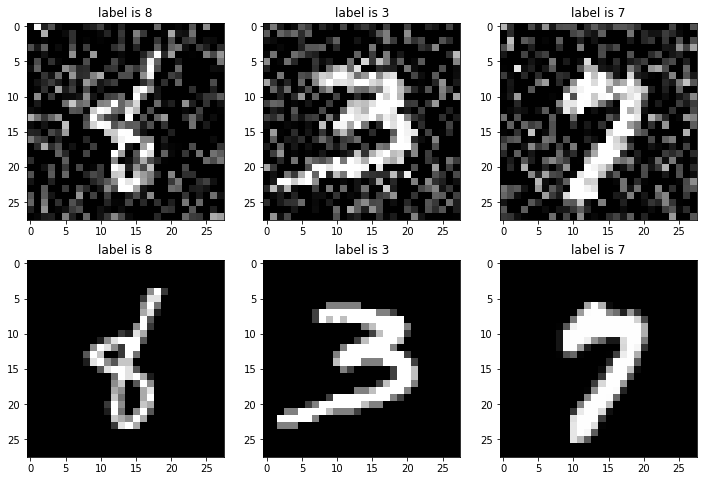

In [102]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 

_, (noisy, original) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(noisy[0][idx][0], cmap='gray')
  ax[0,idx].set_title(f'label is {noisy[1][idx]}')
  ax[1,idx].imshow(original[0][idx][0], cmap='gray')
  ax[1,idx].set_title(f'label is {original[1][idx]}')
fig.show()








#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

Epoch 1: [0/60000] Loss: 132.19300842285156
Epoch 1: [6400/60000] Loss: 121.12434387207031
Epoch 1: [12800/60000] Loss: 63.080806732177734
Epoch 1: [19200/60000] Loss: 60.09614944458008
Epoch 1: [25600/60000] Loss: 58.327659606933594
Epoch 1: [32000/60000] Loss: 58.50870132446289
Epoch 1: [38400/60000] Loss: 59.528053283691406
Epoch 1: [44800/60000] Loss: 57.388397216796875
Epoch 1: [51200/60000] Loss: 55.90739059448242
Epoch 1: [57600/60000] Loss: 58.794158935546875
Test result on epoch 1: Avg loss is 57.87069921875
Epoch 2: [0/60000] Loss: 59.973365783691406
Epoch 2: [6400/60000] Loss: 58.20949935913086
Epoch 2: [12800/60000] Loss: 58.548851013183594
Epoch 2: [19200/60000] Loss: 59.1182861328125
Epoch 2: [25600/60000] Loss: 56.60762023925781
Epoch 2: [32000/60000] Loss: 56.99581527709961
Epoch 2: [38400/60000] Loss: 56.67818832397461
Epoch 2: [44800/60000] Loss: 55.81159210205078
Epoch 2: [51200/60000] Loss: 56.44465255737305
Epoch 2: [57600/60000] Loss: 56.692893981933594
Test resul

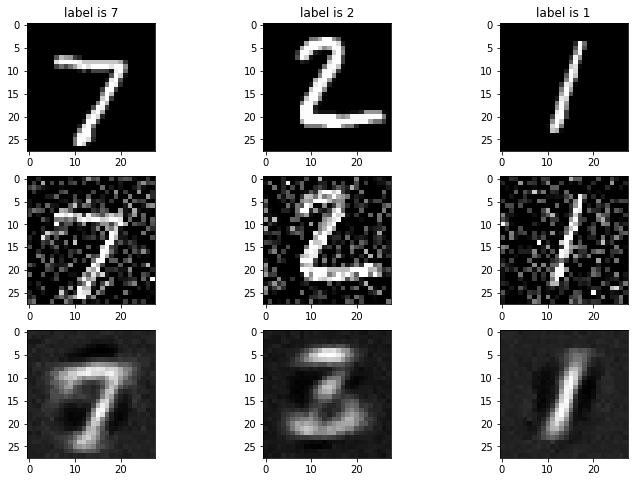

In [104]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)


#  <----------------------------- 1 ----------------------------->

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=64)
    self.en_fc5 = nn.Linear(in_features=64,out_features=32)
    self.en_fc6 = nn.Linear(in_features=32,out_features=16)

    # decoder
    self.de_fc1 = nn.Linear(in_features=16,out_features=32)
    self.de_fc2 = nn.Linear(in_features=32, out_features=64)
    self.de_fc6 = nn.Linear(in_features=64, out_features=784)


  def forward(self, x):

    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = F.relu(self.en_fc5(x))
    x = F.relu(self.en_fc6(x))

    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = F.relu(self.de_fc2(x))
    x = torch.sigmoid(self.de_fc6(x))
    x = x.view(-1, 1, 28, 28)
    return x


#  <----------------------------- 2 ----------------------------->


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')


#  <----------------------------- 3 ----------------------------->

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images,_) in enumerate(train_loader): # Note that we do not need the labels

    images = images[0]
    optimizer.zero_grad()
    images = images.to(device)
    output = AE(images)
    loss = loss_fn(output, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images[0]
      images = images.to(device)
      output = AE(images)
      test_loss += loss_fn(output, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')



train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)



#  <----------------------------- 4 ----------------------------->


batch_idx, (images, _) = next(enumerate(test_loader))
images = images[0]
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())



#  Plot:
_, (noisy, original) = next(enumerate(test_loader))

fig,ax = plt.subplots(3,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(original[0][idx][0], cmap='gray')
  ax[0,idx].set_title(f'label is {original[1][idx]}')
  ax[1,idx].imshow(noisy[0][idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')  
fig.show()




#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [105]:
###########################   <YOUR CODE>  ############################
#  <----------------------------- 1 ----------------------------->
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#################### Hyperparameters ####################
learning_rate = 0.001 
# weight_decay = 1e-5 
batch_size_train, batch_size_test = 64, 1000
epochs = 1

#################### Load Dataset ####################
#  <----------------------------- 2 ----------------------------->
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


#################### Assign to GPU ####################
#  <----------------------------- 3 ----------------------------->
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')





#########################  <END YOUR CODE>  ############################

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [106]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################

  # Part 1: ReconstructionLoss
  ReconstructionLoss = F.binary_cross_entropy(input=output.view(-1, 28*28), target=images.view(-1, 28*28), reduction='sum')

  # Part 2: Regularizer
  Regularizer = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())



  return ReconstructionLoss, Regularizer

  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################


    # Encoding
    self.e_input2hidden = nn.Linear(in_features=784, out_features=500)
    self.e_hidden2mean = nn.Linear(in_features=500, out_features=latent_feature)
    self.e_hidden2logvar = nn.Linear(in_features=500, out_features=latent_feature)

    # Decoding
    self.d_latent2hidden = nn.Linear(in_features=latent_feature, out_features=500)
    self.d_hidden2image = nn.Linear(in_features=500, out_features=784)
    #########################  <END YOUR CODE>  ############################


  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """


    ###########################   <YOUR CODE>  ############################

    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    sample = mu + eps*std
    

    #########################  <END YOUR CODE>  ############################
    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################

    x = x.view(-1, 784)
    x = F.relu(self.e_input2hidden(x))
    mu, log_var = self.e_hidden2mean(x), self.e_hidden2logvar(x)

    z = self.reparameterize(mu,log_var)


    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################

    x = F.relu(self.d_latent2hidden(z))
    x = torch.sigmoid(self.d_hidden2image(x))


    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################

    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)


    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

Epoch 1: [0/60000] Loss: 548.5110473632812
Epoch 1: [6400/60000] Loss: 190.29266357421875
Epoch 1: [12800/60000] Loss: 146.05996704101562
Epoch 1: [19200/60000] Loss: 137.87228393554688
Epoch 1: [25600/60000] Loss: 124.74881744384766
Epoch 1: [32000/60000] Loss: 135.2696533203125
Epoch 1: [38400/60000] Loss: 116.91519165039062
Epoch 1: [44800/60000] Loss: 119.96745300292969
Epoch 1: [51200/60000] Loss: 121.9948959350586
Epoch 1: [57600/60000] Loss: 121.57858276367188
Epoch 2: [0/60000] Loss: 117.5045394897461
Epoch 2: [6400/60000] Loss: 121.43583679199219
Epoch 2: [12800/60000] Loss: 109.6142578125
Epoch 2: [19200/60000] Loss: 114.62559509277344
Epoch 2: [25600/60000] Loss: 119.38723754882812
Epoch 2: [32000/60000] Loss: 111.15480041503906
Epoch 2: [38400/60000] Loss: 113.73797607421875
Epoch 2: [44800/60000] Loss: 120.84281158447266
Epoch 2: [51200/60000] Loss: 114.20442962646484
Epoch 2: [57600/60000] Loss: 112.26768493652344


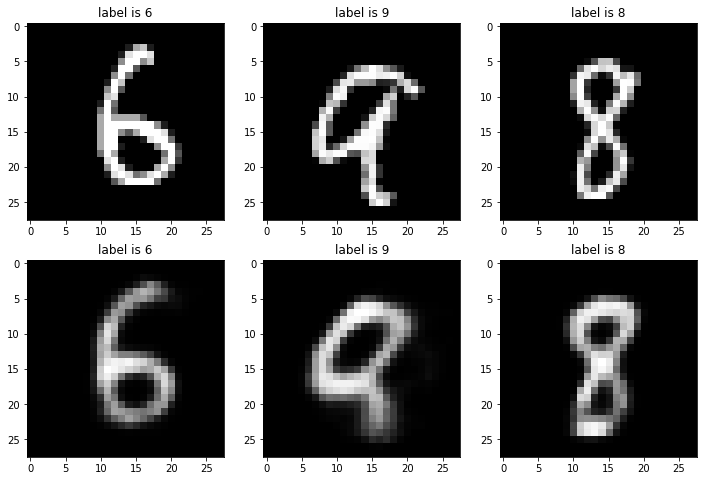

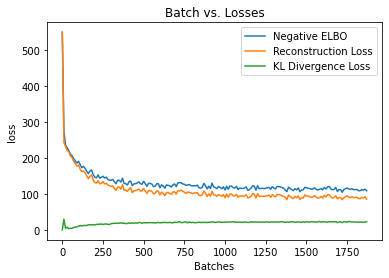

In [107]:
###########################   <YOUR CODE>  ############################
import torchvision
# import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

#  <----------------------------- 1 ----------------------------->

#################### Initilize Optimizer ####################
vae = our_VAE()
vae = vae.to(device)
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate)


#################### Training Phase ####################

negative_elbo = []
reconstruction_loss = []
kl_divergence_loss = []


for epoch in range(epochs+1):
    current_batch = 0
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        reconstructions, mu, log_var = vae(imgs)

        ReconstructionLoss, Regularizer = vae_loss(reconstructions, mu, log_var, imgs)
        loss = ReconstructionLoss + Regularizer

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        if idx % 10 == 0:
          # We record our output every 10 batches
        
          negative_elbo.append(loss.item()/batch_size_train)
          reconstruction_loss.append(ReconstructionLoss/batch_size_train)
          kl_divergence_loss.append(Regularizer/batch_size_train)


        if idx % 100 == 0:
         # We visulize our output every 100 batches
          print(f'Epoch {epoch+1}: [{idx*len(imgs)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


#  <----------------------------- 2 ----------------------------->

#################### Visualizing results ####################

vae.eval()
i = 0
with torch.no_grad():
    fig,ax = plt.subplots(2,3)
    fig.set_size_inches(12,8)

    data = random.sample(list(test_loader), 1)
    for data in random.sample(list(test_loader), 1):
      imgs, label = data
      imgs = imgs.to(device)
      img_0 = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
      img_1 = np.transpose(imgs[1].cpu().numpy(), [1,2,0])
      img_2 = np.transpose(imgs[2].cpu().numpy(), [1,2,0])

      out, mu, logVAR = vae(imgs)
      outimg_0 = out[0].cpu().reshape(28,28)
      outimg_1 = out[1].cpu().reshape(28,28)
      outimg_2 = out[2].cpu().reshape(28,28)

      

      ax[0,0].imshow(np.squeeze(img_0),cmap='gray')
      ax[0,0].set_title(f'label is {label[0]}')

      ax[1,0].imshow(outimg_0, cmap='gray')
      ax[1,0].set_title(f'label is {label[0]}')

      ax[0,1].imshow(np.squeeze(img_1),cmap='gray')
      ax[0,1].set_title(f'label is {label[1]}')

      ax[1,1].imshow(outimg_1, cmap='gray')
      ax[1,1].set_title(f'label is {label[1]}')      

      ax[0,2].imshow(np.squeeze(img_2),cmap='gray')
      ax[0,2].set_title(f'label is {label[2]}')

      ax[1,2].imshow(outimg_2, cmap='gray')
      ax[1,2].set_title(f'label is {label[2]}')

    fig.show() 


#  <----------------------------- 3 ----------------------------->

#################### Losses Plot ####################

losses_fig = plt.figure(2)
plt.plot(np.arange(len(negative_elbo))*10, negative_elbo)
plt.plot(np.arange(len(reconstruction_loss))*10, reconstruction_loss)
plt.plot(np.arange(len(kl_divergence_loss))*10, kl_divergence_loss)
plt. title ( 'Batch vs. Losses')
plt. ylabel ('loss')
plt.xlabel ('Batches')
plt. legend (['Negative ELBO', 'Reconstruction Loss', 'KL Divergence Loss'], loc='upper right')
plt.show()

#########################  <END YOUR CODE>  ###########################


### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [ ]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

In [ ]:
###########################   <YOUR CODE>  ############################

#########################  <END YOUR CODE>  ###########################

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

In [ ]:
###########################   <YOUR CODE>  ############################

#########################  <END YOUR CODE>  ###########################